In [1]:
# do the required imports
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# imports sklearn
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

In [2]:
filename = r'C:\Users\m1srh\OneDrive - Carl Zeiss AG\Projects\ATOMIC\Object_Classification\LargestRegionsTable_A00094.csv'

def check_separator(csvfile):

    reader = pd.read_csv(csvfile, sep=None, engine='python', iterator=True)
    sep = reader._engine.data.dialect.delimiter
    reader.close()

    return sep

def convert_dec_sep(df, np):

    for id in range(np, len(df.columns)):
        try:
            df.iloc[:, id] = df.iloc[:, id].str.replace(',', '.').astype('float')
        except:
            print('No correction of types possible for column: ', df.columns[id])
            
    return df

In [3]:
# check the used separator
sep = check_separator(filename)

# read the CSV table containing all the single object data
df_single = pd.read_csv(filename, sep=sep)

# get headers and number of measurement parameters
headers = df_single.head(0)

df_single[:3]

,IndexRegion::IndexRegion!!I,ParticleType::ParticleType,Feretmaximum::Feretmaximum!!R,Fibrelength::Fibrelength!!R,Feretminimum::Feretminimum!!R,Maximuminscribedcircle::Maximuminscribedcircle!!R,Diameterfilled::Diameterfilled!!R,Maximumwidth::Maximumwidth!!R,Feretratio::Feretratio!!R,Formcircle::Formcircle!!R,...,Densitometricsum::Densitometricsum!!R,Rectangleheight::Rectangleheight!!R,Rectanglewidth::Rectanglewidth!!R,Boundleft::Boundleft!!R,Boundtop::Boundtop!!R,Boundwidth::Boundwidth!!R,Boundheight::Boundheight!!R,ImagePhaseName::ImagePhaseName,ImageStagePositionX::ImageStagePositionX!!R,ImageStagePositionY::ImageStagePositionY!!R
0,NaN,NaN,µm,µm,µm,µm,µm,µm,NaN,NaN,...,Grey,µm,µm,µm,µm,µm,µm,NaN,µm,µm
1,6949.0,Non-metallic,654.903759093014,1819.31611526565,409.831338002443,332.62587822014,474.881660355846,424.838992974239,0.625789,0.260684,...,31475387,425.889348770745,654.903759093014,4690.79332552693,9037.43413348946,424.290105386417,653.176229508197,ShiftImage__,0,0
2,8770.0,Non-metallic,268.08208404029,398.502449835939,70.7370943457009,18.6621779859485,69.9814438493878,37.3243559718969,0.263864,0.082049,...,715076,72.2285918347547,268.08208404029,13089.8711943794,11381.7330210773,264.014929742389,94.9575526932084,ShiftImage__,0,0


In [4]:
# rename table columns for better readability
cols={"IndexRegion::IndexRegion!!I":"index",
      "ParticleType::ParticleType":"type",
      "Feretmaximum::Feretmaximum!!R":"feretmax",
      "Fibrelength::Fibrelength!!R":"fiberlength",
      "Feretminimum::Feretminimum!!R":"feretmin",
      "Maximuminscribedcircle::Maximuminscribedcircle!!R":"maxcircle",
      "Diameterfilled::Diameterfilled!!R":"diamfilled",
      "Maximumwidth::Maximumwidth!!R":"maxwidth",
      "Feretratio::Feretratio!!R":"feretratio",
      "Formcircle::Formcircle!!R":"formcircle",
      "Areafilled::Areafilled!!R":"areafilled",
      "Areaconvex::Areaconvex!!R":"areaconv",
      "Radius::Radius!!R":"radius",
      "Perimeterfilled::Perimeterfilled!!R":"perimfilled",
      "Perimeterconvex::Perimeterconvex!!R":"perimconv",
      "PerimeterCroftonfilled::PerimeterCroftonfilled!!R":"perimcrotfilled",
      "CenterX::CenterX!!R":"centerx",
      "CenterY::CenterY!!R":"centery",
      "Densitometricmaximum::Densitometricmaximum!!R":"densmax",
      "Densitometricmean::Densitometricmean!!R":"densmean",
      "Densitometricminimum::Densitometricminimum!!R":"densmin",
      "Densitometricstandarddeviation::Densitometricstandarddeviation!!R":"densstd",
      "Densitometricsum::Densitometricsum!!R":"denssum",
      "Rectangleheight::Rectangleheight!!R":"rectheight",
      "Rectanglewidth::Rectanglewidth!!R":"rectwidth",
      "Boundleft::Boundleft!!R":"boundleft",
      "Boundtop::Boundtop!!R":"boundtop",
      "Boundwidth::Boundwidth!!R":"boundwidth",
      "Boundheight::Boundheight!!R":"boundheight",
      "ImagePhaseName::ImagePhaseName":"imgname",
      "ImageStagePositionX::ImageStagePositionX!!R":"stagex",
      "ImageStagePositionY::ImageStagePositionY!!R":"stagey"}

# rename colums
df_single.rename(columns=cols, inplace=True)

In [5]:
# remove columns not needed for classification
df_class = df_single.drop(columns=['stagex',
                                   'stagey',
                                   'index',
                                   'centerx',
                                   'centery',
                                   'imgname',
                                   'boundleft',
                                   'boundtop'], inplace=False)

# remove rows with units from dataframe
df_class.drop([0], inplace=True)


# convert decimal separators to point "."
df_class = convert_dec_sep(df_class, 0)

df_class[:3]

No correction of types possible for column:  type
No correction of types possible for column:  feretratio
No correction of types possible for column:  formcircle


,type,feretmax,fiberlength,feretmin,maxcircle,diamfilled,maxwidth,feretratio,formcircle,areafilled,...,perimcrotfilled,densmax,densmean,densmin,densstd,denssum,rectheight,rectwidth,boundwidth,boundheight
1,Non-metallic,654.903759,1819.316115,409.831338,332.625878,474.881660,424.838993,0.625789,0.260684,177117.175063,...,2921.985566,150.0,53.742162,16.0,6.505407,31475387.0,425.889349,654.903759,424.290105,653.176230
2,Non-metallic,268.082084,398.502450,70.737094,18.662178,69.981444,37.324356,0.263864,0.082049,3846.410916,...,767.530273,255.0,56.049224,24.0,15.721826,715076.0,72.228592,268.082084,264.014930,94.957553
3,Non-metallic,253.904597,277.873718,22.832846,18.662178,64.582249,20.857728,0.089927,0.136462,3275.791172,...,549.234529,83.0,49.409547,19.0,11.125007,537230.0,22.832846,253.904597,46.106557,250.841628


In [6]:
# define label array from labels
label = np.zeros((df_class.shape[0],), dtype=np.integer)

index = -1
for t in df_class['type']:
    index += 1
    if t == 'Non-metallic':
        label[index] = 0
    if t == 'Metallic':
        label[index] = 1

# define class names
class_names = ['Non-metallic', 'Metallic']

In [7]:
# remove type column
df_train = df_class.drop(columns=['type'], inplace = False)

# get feature names
feature_list = list(df_train.columns)

# show dataset
print(df_train.shape)
df_train[:3]

(500, 23)


,feretmax,fiberlength,feretmin,maxcircle,diamfilled,maxwidth,feretratio,formcircle,areafilled,areaconv,...,perimcrotfilled,densmax,densmean,densmin,densstd,denssum,rectheight,rectwidth,boundwidth,boundheight
1,654.903759,1819.316115,409.831338,332.625878,474.881660,424.838993,0.625789,0.260684,177117.175063,198014.097708,...,2921.985566,150.0,53.742162,16.0,6.505407,31475387.0,425.889349,654.903759,424.290105,653.176230
2,268.082084,398.502450,70.737094,18.662178,69.981444,37.324356,0.263864,0.082049,3846.410916,13453.826996,...,767.530273,255.0,56.049224,24.0,15.721826,715076.0,72.228592,268.082084,264.014930,94.957553
3,253.904597,277.873718,22.832846,18.662178,64.582249,20.857728,0.089927,0.136462,3275.791172,4722.341973,...,549.234529,83.0,49.409547,19.0,11.125007,537230.0,22.832846,253.904597,46.106557,250.841628


In [8]:
# optiional data cleaning
df_train.drop(df_train[df_train.feretmax < 15.29].index, inplace=True)
print(df_train.shape)
df_train[:3]

(500, 23)


,feretmax,fiberlength,feretmin,maxcircle,diamfilled,maxwidth,feretratio,formcircle,areafilled,areaconv,...,perimcrotfilled,densmax,densmean,densmin,densstd,denssum,rectheight,rectwidth,boundwidth,boundheight
1,654.903759,1819.316115,409.831338,332.625878,474.881660,424.838993,0.625789,0.260684,177117.175063,198014.097708,...,2921.985566,150.0,53.742162,16.0,6.505407,31475387.0,425.889349,654.903759,424.290105,653.176230
2,268.082084,398.502450,70.737094,18.662178,69.981444,37.324356,0.263864,0.082049,3846.410916,13453.826996,...,767.530273,255.0,56.049224,24.0,15.721826,715076.0,72.228592,268.082084,264.014930,94.957553
3,253.904597,277.873718,22.832846,18.662178,64.582249,20.857728,0.089927,0.136462,3275.791172,4722.341973,...,549.234529,83.0,49.409547,19.0,11.125007,537230.0,22.832846,253.904597,46.106557,250.841628


In [9]:
# get data as numpy array from dataframe
data = df_train.values
print(type(data), data.shape)

<class 'numpy.ndarray'> (500, 23)


In [10]:
# split data for training
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.5, random_state=0)

In [11]:
# scale data
scale = True

if scale:
    # Feature Scaling
    sc = StandardScaler()
    data_train = sc.fit_transform(data_train)
    data_test = sc.transform(data_test) 

In [12]:
# iniate classifier
classifier = RandomForestClassifier(n_estimators=10,
                                    bootstrap=True,
                                    random_state=20,
                                    verbose=0)

# build a forest of trees from the training set (data, label)
classifier.fit(data_train, label_train)

# predict class for data
label_pred = classifier.predict(data_test)

# show results
confm_notnormed = confusion_matrix(label_test, label_pred)
confm_normed = np.round(confm_notnormed.astype('float') / confm_notnormed.sum(axis=1)[:, np.newaxis], 2)
class_report = classification_report(label_test, label_pred)
acc_score = accuracy_score(label_test, label_pred)
fi = classifier.feature_importances_

print(confm_notnormed)
print('------------------------------------')
print(confm_normed)
print('------------------------------------')
print(class_report)
print('------------------------------------')
print('Accuray Score : ', acc_score)

[[157   6]
 [  9  78]]
------------------------------------
[[0.96 0.04]
 [0.1  0.9 ]]
------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       163
           1       0.93      0.90      0.91        87

    accuracy                           0.94       250
   macro avg       0.94      0.93      0.93       250
weighted avg       0.94      0.94      0.94       250

------------------------------------
Accuray Score :  0.94


In [13]:
feature_imp = {'Features': feature_list, 'Importance': fi}
fimp = pd.DataFrame(data=feature_imp)

# show feature importance
fimp

,Features,Importance
0,feretmax,0.014672
1,fiberlength,0.012153
2,feretmin,0.005036
3,maxcircle,0.014504
4,diamfilled,0.012264
5,maxwidth,0.004285
6,feretratio,0.035047
7,formcircle,0.009079
8,areafilled,0.021289
9,areaconv,0.005650


In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=16,
                    color="red" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=cax)
    
    return ax

Confusion matrix, without normalization
Normalized confusion matrix


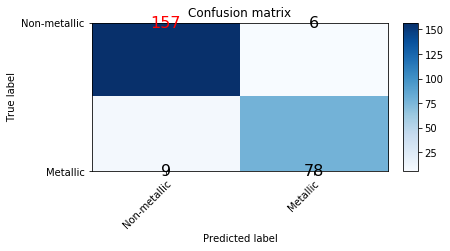

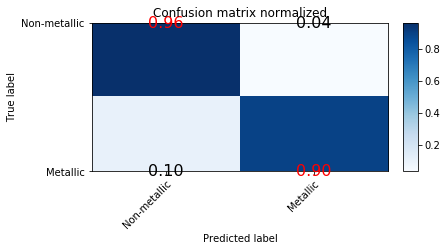

In [15]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(label_test, label_pred, classes=np.asarray(class_names), normalize=False,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(label_test, label_pred, classes=np.asarray(class_names), normalize=True,
                      title='Confusion matrix normalized')



In [ ]:
rs_max = 20
estimator_max = 20

rs_estimator_matrix = np.zeros((rs_max, estimator_max-1), dtype=np.float)

from tqdm import tqdm, tqdm_notebook

for n in tqdm_notebook(range(1, estimator_max, 1)):
    for rstate in range(0, rs_max, 1):

        # iniate classifier
        classifier = RandomForestClassifier(n_estimators=n,
                                            bootstrap=True,
                                            random_state=rstate,
                                            verbose=0)
       
        # build a forest of trees from the training set (data, label)
        classifier.fit(data_train, label_train)
        
        # predict class for data
        label_pred = classifier.predict(data_test)
        
        # show results
        rs_estimator_matrix[rstate, n-1] = accuracy_score(label_test, label_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(rs_estimator_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_xlabel('n_estimators')
ax.set_ylabel('random_state')
ax.set_title('Accuray')
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)